# Data Exploration Project

### Import relevanter Klassen/Methoden/Funktionen

In [81]:
# Data Processing
import pandas as pd
import numpy as np
from numpy import quantile, where, std

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesen Test
import scipy.stats as stats

# Train-Test-Split
from sklearn.model_selection import train_test_split

# Sklearn Pipeline
from sklearn.pipeline import Pipeline

# Imputer
from sklearn.impute import KNNImputer

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Over-/Undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Outlier
from sklearn.neighbors import LocalOutlierFactor

# Evaluierung 
from yellowbrick.classifier import ROCAUC, ClassPredictionError
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_val_predict
from statistics import mean

# Grid Search
from sklearn.model_selection import GridSearchCV

# Machine Learning Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Deep Learning
import tensorflow as tf
from functools import partial

# Other
from datetime import date


In [82]:
pd.options.mode.chained_assignment = None  # default='warn'

# Import der Daten und initiale Bereinigung

In [83]:
emotional_events = pd.read_csv('dataset/emotional_events.csv')

# Preprocessing Data Types
emotional_events['valence'] = emotional_events['valence'].replace('AO07', '7').astype(float)
emotional_events['arousal'] = emotional_events['arousal'].replace('AO07', '7').astype(float)

emotional_events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                0 non-null      float64
 1   userId            1641 non-null   int64  
 2   task_type         1641 non-null   object 
 3   task              1641 non-null   int64  
 4   input_type        1641 non-null   object 
 5   input             1636 non-null   object 
 6   input_assessment  0 non-null      float64
 7   confidence        405 non-null    float64
 8   understanding     405 non-null    float64
 9   valence           1244 non-null   float64
 10  arousal           1244 non-null   float64
 11  task_start        405 non-null    float64
 12  task_end          1155 non-null   float64
 13  task_time         891 non-null    float64
dtypes: float64(9), int64(2), object(3)
memory usage: 179.6+ KB


In [84]:
# Filtering Data

ee = emotional_events[emotional_events['task_type'] == 'information_finding']
ee.loc[:, 'valence_high'] = np.where(ee['valence'] > 3, 1, 0)
ee.loc[:, 'arousal_high'] = np.where(ee['arousal'] > 3, 1, 0)
len(ee)


1155

x: valence
y: arousal

|2|4|
|---|---|
|1|3|

In [85]:
def get_emotion_score(df):
    if df['valence_high'] == 1 and df['arousal_high'] == 1:
        return 4
    elif df['valence_high'] == 1 and df['arousal_high'] == 0:
        return 3
    elif df['valence_high'] == 0 and df['arousal_high'] == 1:
        return 2
    elif df['valence_high'] == 0 and df['arousal_high'] == 0:
        return 1
    else:
        return np.nan
    
ee['emotion_quartile'] = ee.apply(get_emotion_score, axis=1)
ee.emotion_quartile.value_counts()

emotion_quartile
1    552
4    293
2    247
3     63
Name: count, dtype: int64

In [86]:
ee.head()

,id,userId,task_type,task,input_type,input,input_assessment,confidence,understanding,valence,arousal,task_start,task_end,task_time,valence_high,arousal_high,emotion_quartile
0,NaN,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",NaN,6.0,7.0,5.0,6.0,1.719301e+12,1.719301e+12,56.03,1,1,4
1,NaN,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN,0,0,1
2,NaN,124,information_finding,2,final_output,Dauert zu lange,NaN,1.0,1.0,1.0,5.0,1.719301e+12,1.719302e+12,103.50,0,1,2
3,NaN,124,information_finding,2,prompt,Nennen Sie die Einwohnerzahlen die sich aus de...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN,0,0,1
4,NaN,124,information_finding,3,final_output,Alt-Stühlinger,NaN,2.0,3.0,3.0,5.0,1.719301e+12,1.719301e+12,124.84,0,1,2


In [87]:
ee.describe()

,id,userId,task,input_assessment,confidence,understanding,valence,arousal,task_start,task_end,task_time,valence_high,arousal_high,emotion_quartile
count,0.0,1155.000000,1155.000000,0.0,405.000000,405.000000,758.000000,758.000000,4.050000e+02,1.155000e+03,405.000000,1155.000000,1155.000000,1155.000000
mean,NaN,179.930736,3.035498,NaN,3.520988,3.595062,3.179420,4.234828,1.719880e+12,6.041917e+11,241.577679,0.308225,0.467532,2.083983
std,NaN,33.896908,1.403618,NaN,1.977016,1.890302,1.263029,1.358082,4.082929e+08,8.202155e+11,172.433619,0.461960,0.499161,1.241559
min,NaN,124.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.719301e+12,1.719301e+09,12.710000,0.000000,0.000000,1.000000
25%,NaN,151.000000,2.000000,NaN,1.000000,2.000000,2.000000,3.000000,1.719564e+12,1.719826e+09,148.240000,0.000000,0.000000,1.000000
50%,NaN,178.000000,3.000000,NaN,4.000000,4.000000,3.000000,4.000000,1.719880e+12,1.720327e+09,208.990000,0.000000,0.000000,2.000000
75%,NaN,209.000000,4.000000,NaN,5.000000,5.000000,4.000000,5.000000,1.720269e+12,1.719578e+12,294.320000,1.000000,1.000000,4.000000
max,NaN,238.000000,5.000000,NaN,7.000000,7.000000,6.000000,7.000000,1.720543e+12,1.720544e+12,1862.960000,1.000000,1.000000,4.000000


In [88]:
ee.head(3)

,id,userId,task_type,task,input_type,input,input_assessment,confidence,understanding,valence,arousal,task_start,task_end,task_time,valence_high,arousal_high,emotion_quartile
0,NaN,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",NaN,6.0,7.0,5.0,6.0,1.719301e+12,1.719301e+12,56.03,1,1,4
1,NaN,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN,0,0,1
2,NaN,124,information_finding,2,final_output,Dauert zu lange,NaN,1.0,1.0,1.0,5.0,1.719301e+12,1.719302e+12,103.50,0,1,2


In [89]:
# Replace target variable values by numeric representation
ee['class'] = ee['emotion_quartile']

In [90]:
#Drop irrelevant columns
data_unproc = ee.drop(['id', 'userId', 'task_start', 'task_end'], axis=1)

# Datenvisualisierung

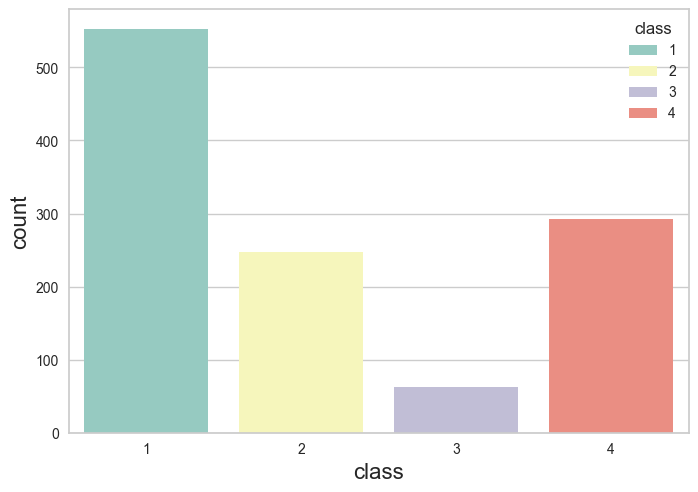

In [91]:
ax = sns.countplot(x="class", data=data_unproc, palette="Set3", hue="class", legend=True);
ax.set_xlabel("class", fontsize = 16)
ax.set_ylabel("count", fontsize = 16)
plt.show()

In [92]:
data_unproc["class"].value_counts()

class
1    552
4    293
2    247
3     63
Name: count, dtype: int64

Klasse **1**: low valence and arousal <br>
Klasse **2**: high arousal, low valence  <br>
Klasse **3**: low arousal, high valence <br>
Klasse **4**: high arousal, valence <br>

Im Balkendiagramm ist eine ungleiche Klassenverteilung zu erkennen, welche später entweder beim Training der Modelle und deren Auswertung berücksichtigt oder vorab behoben werden muss.

#### Korrelations-Heatmap
In der nachfolgenden Codezeile wird eine Heatmap erzeugt. Diese stellt grafisch die Korrelation zwischen zweier Variablen unseres Datensatzes dar. In diesem Fall bedeutet eine dunkelere Farbe in der Heatmap, dass die Variablen entlang der X und Y-Achse mehr miteinander korrelieren.

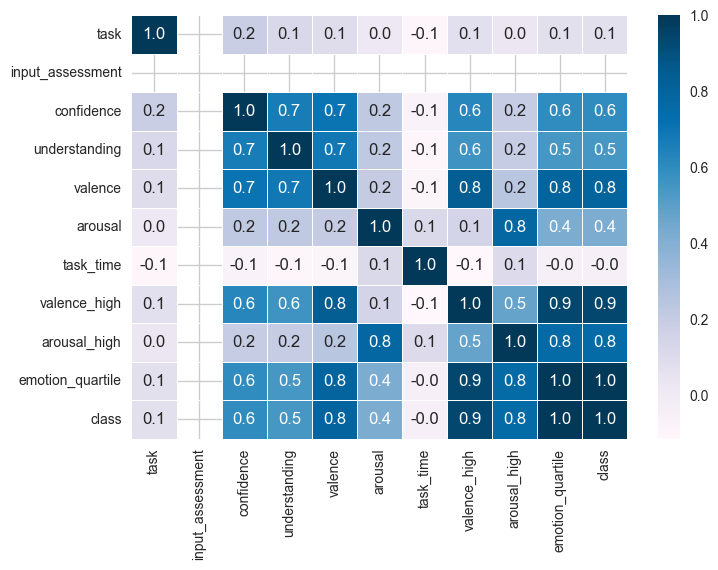

<Figure size 1400x1000 with 0 Axes>

In [93]:
ax = plt.axes()
plt.figure(figsize = (14,10))
sns.heatmap(data_unproc.select_dtypes(include=['number']).corr(), annot = True, fmt = ".1f", linewidths = .7, cmap="PuBu", ax = ax)
plt.show()

Korrelationen mit Klasse darf nicht verwendet werden, da wir eine Klassifikation vorliegen haben und die Klassenwerte 0,1,2 nicht in einer Rangordnung stehen.

In [94]:
corr = data_unproc.select_dtypes(include=['number']).corr()

corr["class"].sort_values(ascending=False)

emotion_quartile    1.000000
class               1.000000
valence_high        0.935373
valence             0.791916
arousal_high        0.755966
confidence          0.595980
understanding       0.545838
arousal             0.419271
task                0.069892
task_time          -0.047734
input_assessment         NaN
Name: class, dtype: float64

In [95]:
# Visualierung der Korrelation innerhalb der Klassen

# fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 16))
# fig.set_dpi(100)
# ax = sns.heatmap(data_unproc[data_unproc['class']==0][['u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[0], cmap='PuBu', annot=True)
# ax.set_title('Galaxy')
# ax = sns.heatmap(data_unproc[data_unproc['class']==1][['u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[1], cmap='PuBu', annot=True)
# ax.set_title('Star')
# ax = sns.heatmap(data_unproc[data_unproc['class']==2][['u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[2], cmap='PuBu', annot=True)
# ax = ax.set_title('Quasar')

Quasar korreliert bei Lichtmesswerten stark, da er insgesamt nur wenig Licht selbst abgibt. 

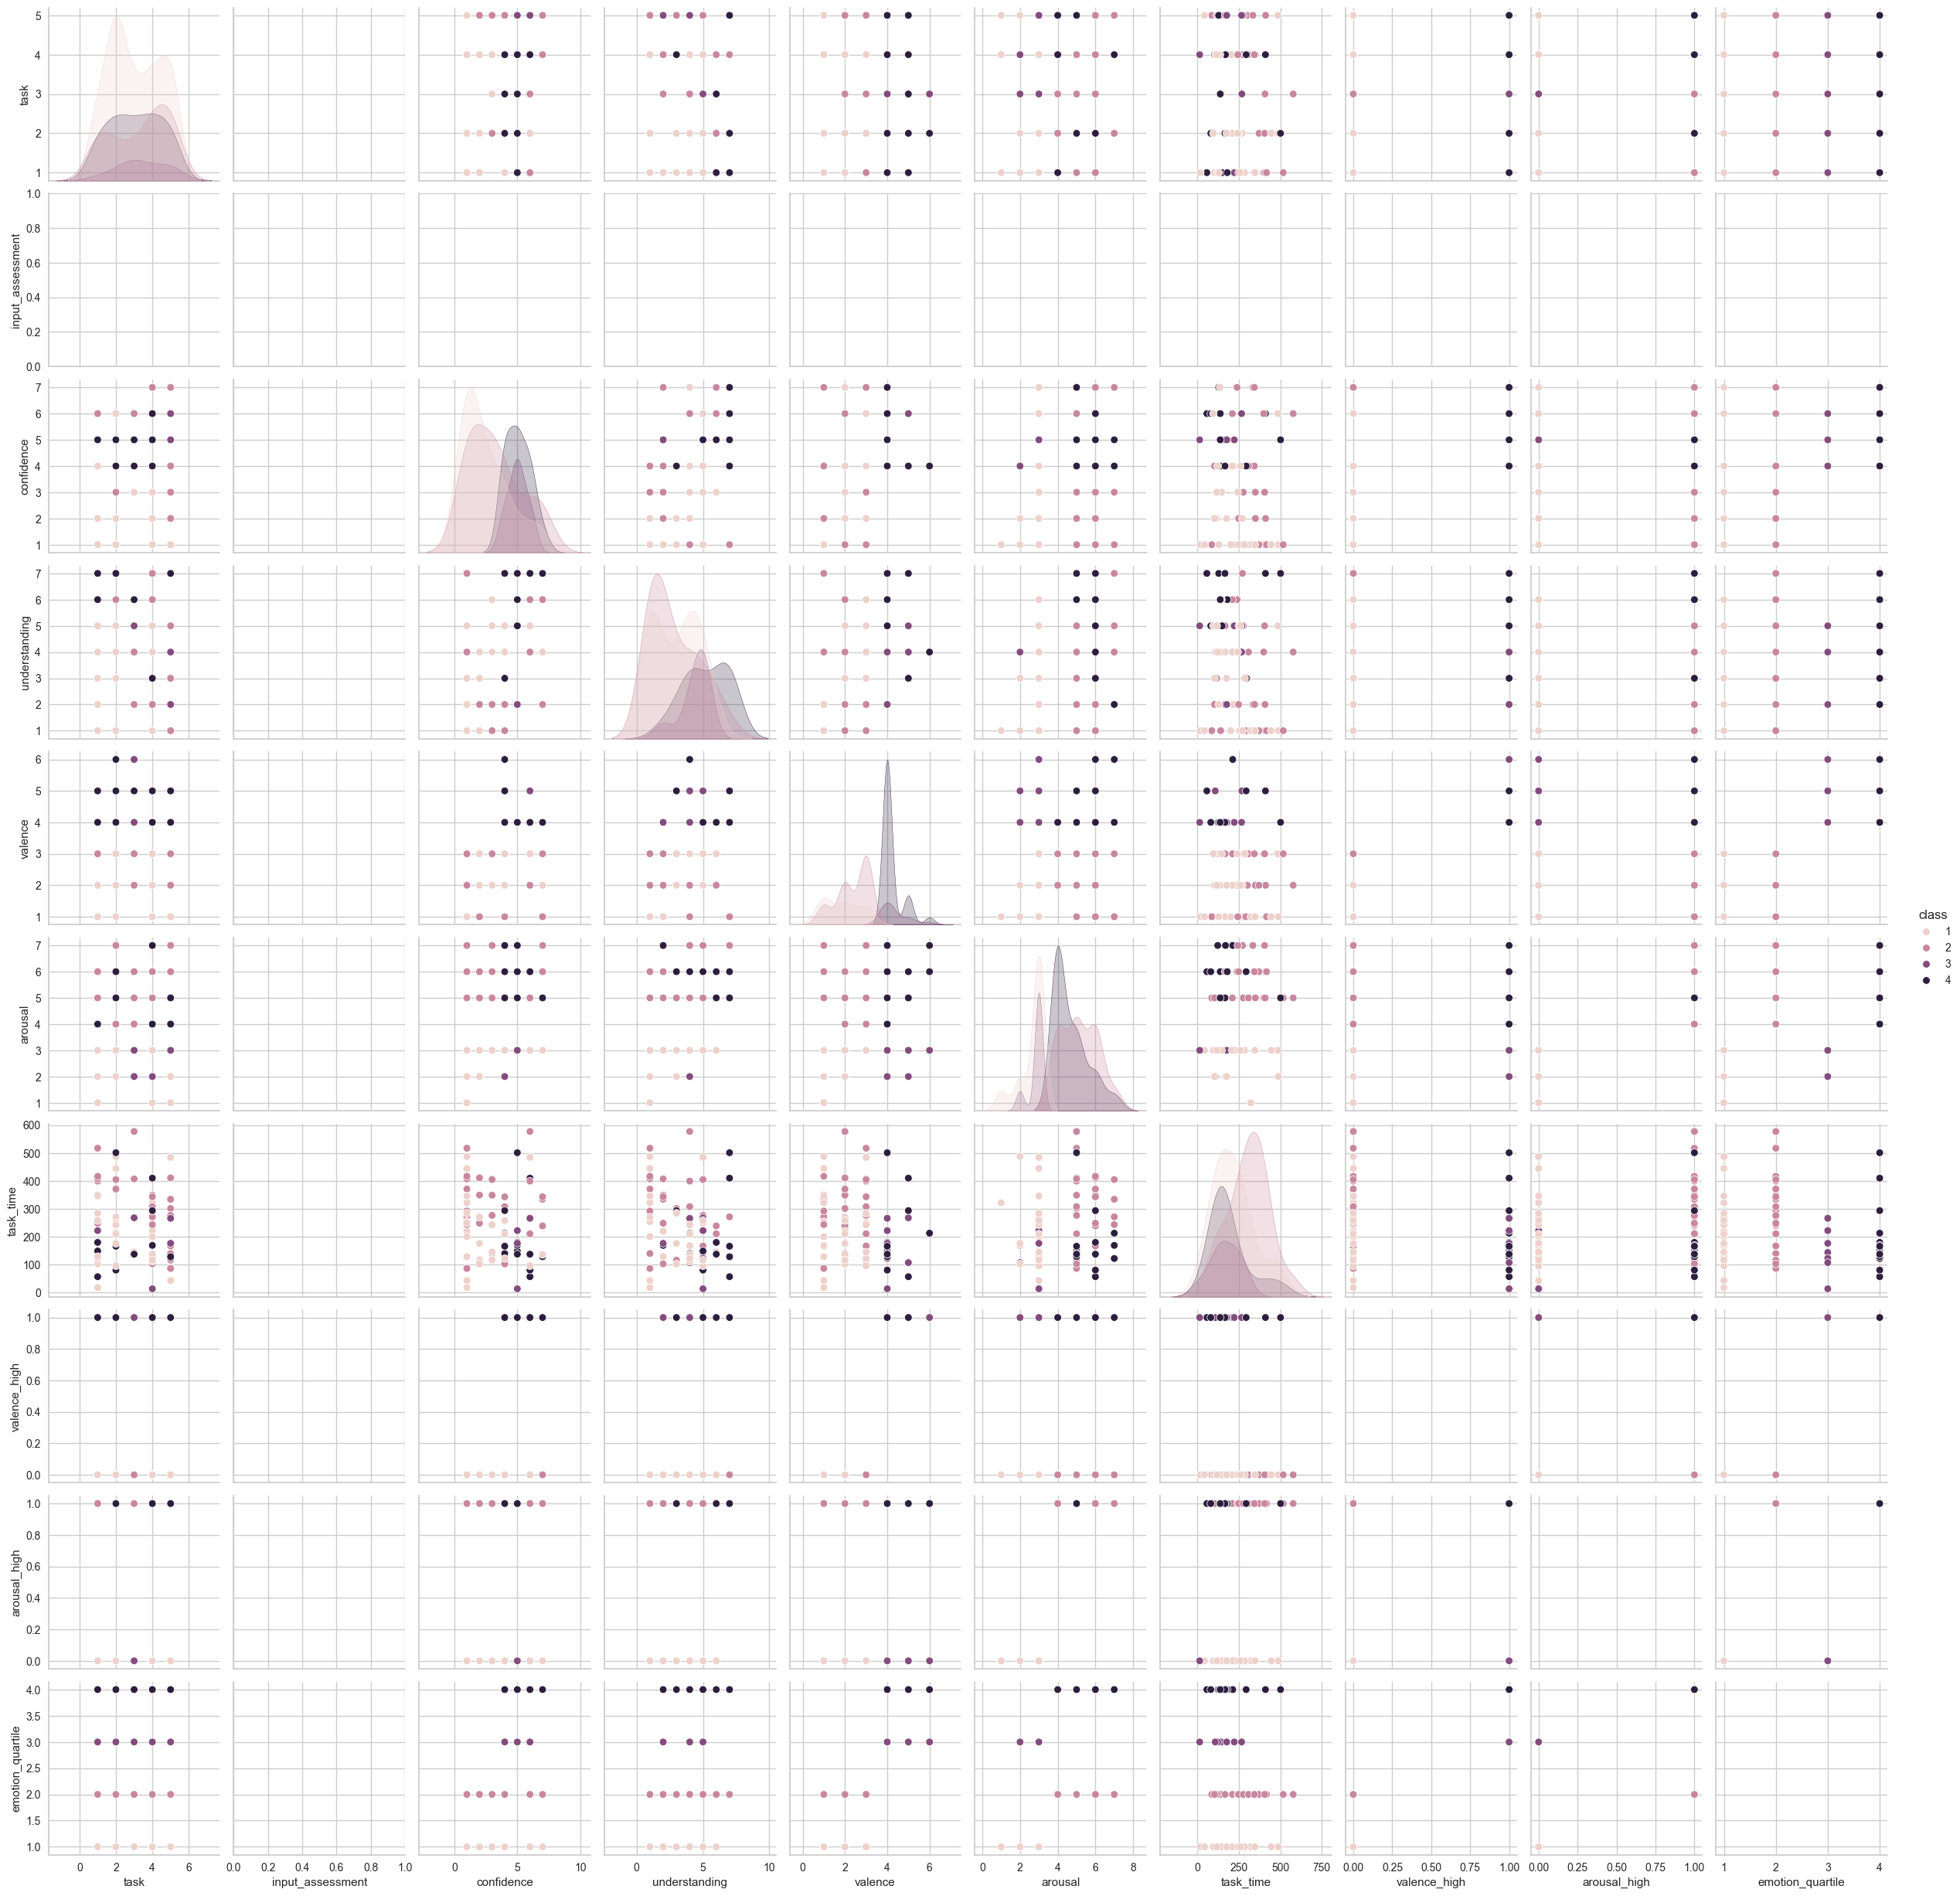

In [96]:
sns.pairplot(data=data_unproc[::5], #for performace reasons only every fifth values is displayed
             hue='class')
plt.show()

Im obigen Plot ist die positive Korrelation von einigen Features erkennbar. Dies bestätigt visuell die positiven Korrelationswerte aus den Korellationsheatmaps oben. Ein deutliche Clusterbildung ist zudem beim Redshift erkennbar. Während der Redshift von Sternen vergleichsweise gering ist, weisen Galaxien und Quasare höhere Werte auf. Die wird im Plot besser gezeigt:

In [97]:
# fig = plt.figure(figsize=(12, 8))
# sns.scatterplot(x='alpha', y='delta', data=data_unproc, hue='class')
# plt.title('Distribution of Classes by alpha and delta angle')
# plt.show()

# Train-Test-Split

Für das Trainieren und Evaluieren von Modellen werden 3 Datensätze empfohlen:

**Trainingsdaten**:

Diese werden für das Modelltraining genutzt.

**Validierungsdaten**:

Nach dem Training gilt es ein Modell auf dessen Güte zu testen. Hierfür sind grundsätzlich Testdaten vorgesehen, welche vom Modell vorher noch nicht gesehen und explizit von den Trainingsdaten ausgeschlossen wurden. Die Findung des besten Modells inklusive dessen Hyperparameter ist ein iterativer Prozess und ist dann beendet, sofern die gemessene Güte auf den Testdaten einen angemessenen Grad erreicht. Dies hat jedoch den Nachteil, dass das Modell extra so trainiert wurde, dass es auf diesen speziellen Testdatensatz optimal performt und auf tatsächlich neuen Daten in Produktion deutlich schlechter abschneiden könnte. Eine Lösung dieses Problems ist die sogenannte "Holdout validation": Ein Teil der Trainingsdaten wird dazu benutzt, um die optimalen Modelle zu finden. Trainiert werden diese Modelle auf dem nun reduzierten Trainigsdaten.

**Testdaten**:

Um eine Einschätzung zu bekommen, wie gut das Modell in Produktion performen wird, wird das Modell final mit den bis dahin noch nie gesehenen Testdaten evaluiert.


Für das Modelltraining der klassichen ML-Algorithmen (NaiveBayes, SVM, RandomForest,...) verzichten wir auf einen 3er-Split, da wir Hyperparameter-Optimierung mit Hilfe der Cross-Validation durchführen, wodurch kein Bias bezüglich des Testdatensatzes entsteht, da dieser erst bei der finalen Modellbewertung benutzt wird.
Für das Training eines neuronalen Netzes und zur Ermittlung dessen optimaler Hyperparameter wurde jedoch ein Validierungsdatensatz genutzt, welcher jedoch erst in der entsprechenden Code-Zelle erstellt wird.

In [98]:
#TODO: gescheites Handling der NaN Werte
data_unproc = data_unproc.dropna(axis=1, how='all').dropna(axis=0, how='any')

data_unproc = data_unproc.dropna(subset=['emotion_quartile'])

X = data_unproc.drop(['class'], axis=1)   # independant features
y = data_unproc['class']				# dependant variable

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [99]:
X_test.head()

,task_type,task,input_type,input,confidence,understanding,valence,arousal,task_time,valence_high,arousal_high,emotion_quartile
287,information_finding,1,final_output,Keine,1.0,1.0,1.0,5.0,321.74,0,1,2
867,information_finding,4,final_output,?=,1.0,1.0,1.0,1.0,74.69,0,0,1
1559,information_finding,1,final_output,"Alt-Betzenhausen, Landwasser, Lehen, Mundenhof...",3.0,3.0,2.0,3.0,206.35,0,0,1
131,information_finding,4,final_output,11201,4.0,4.0,4.0,7.0,121.49,1,1,4
170,information_finding,3,final_output,Alt-Stühlinger,2.0,4.0,2.0,5.0,220.36,0,1,2


In [100]:
y_test.head()

287     2
867     1
1559    1
131     4
170     2
Name: class, dtype: int64

# Datenbereinigung und Vorverarbeitung

Bei der Betrachtung des Datensatzes und der Visualisierung ist unmittelbar erkennbar, dass es eine Zeile existiert, wobei mehrere Attribute den Wert -9999 annehmen. Dabei wird ein Messfehler angenommen. Mit Hilfe folgender Funktion werden Zeilen im Trainingsdatensatz ermittelt, welche diese Messfehler vorweisen, bevor diese den Trainingsdaten entnommen werden. 

In [101]:
# Returns false if line has value -9999 in any column
def check_nine(row):
    for index, value in row.items():
        if int(value) == -9999:
            return False
    return True

print(f'Row count before: {len(X_train)}')

# Get indices, where a line yields a -9999 value (True = No -9999, False = -9999 value)
indices_wo_nine = X_train.apply(lambda row: check_nine(row), axis=1)
X_train = X_train[indices_wo_nine]
y_train = y_train[indices_wo_nine]
print(f'Row count after: {len(X_train)}')

Row count before: 283


ValueError: invalid literal for int() with base 10: 'information_finding'

In [ ]:
print(f'Count of duplicates: {data_unproc.duplicated().sum()}')
# No need of deleting 

### Ausreißer entfernen

Im Folgenden werden Ausreißer im Datensatz identifiziert und entfernt. Dabei wird ein Algorithmus namens "Local Outlier Factor" (LOF) verwendent. Dabei wird die Dichte eines Punktes mit den Dichten seiner Nachbarn verglichen. Die Nachbarn werden via K-Nearest Neighbor ermittelt, bevor anschließend die Dichte ermittelt wird, abhängig davon wie weit diese entfernt sind. "Normale" Datenpunkte haben Werte nahe 1, während Ausreißer zu größeren Werten neigen. Datenpunkte mit größeren Werten werden demnach von den Trainingsdaten entfernt.

Für die Entfernung der Ausreißer in den Trainingsdaten haben wir uns entschieden, weil wir dadurch höhere Modell-Performances auf den Test-Daten erzielen konnten.
Für den LOG-Algorithmus haben wir uns entschieden, weil dieser im Gegensatz zu vielen anderen Verfahren mit Bereichen unterschiedlicher Dichte in demselben Datensatz umgehen kann. Datenpunkte mit einer „mittleren“ Dichte in einer Umgebung mit „hoher“ werden von LOF als Ausreißer klassifiziert, während ein Punkt mit „mittlerer“ Dichte in einer „dünnen“ Umgebung explizit nicht als solcher erkannt wird.

Quelle:
https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf


In [ ]:
# Objekt der Ausreißererkennung wird instanziiert
# Standardmäßig werden 20 Nachbarn zur Berechnung des Wertes betrachtet
lof_model = LocalOutlierFactor()

# Algorithmus wird auf den Trainingsdaten angewandt und berechnet die LocalOutlierFactor-Werte
lof_model.fit_predict(X_train)

# Das Objektattribute "negative_outlier_factor_" liefert gewünschten LocalOutlierFactor-Werte.
# Jedoch sind diese Werte mit -1 multipliziert -> Werte nahe -1 gelten als "normal" und viel kleinere Werte als Ausreißer
lof_values = lof_model.negative_outlier_factor_

# Als Schwellwert wird das 0.03-Perzentil der LOF-Werte definiert.
thresh = quantile(lof_values, .03)

# Ermittlung der Datenpunkte, wobei der LOF-Wert des Datenpunktes unter dem definierten Schwellwert liegt (-> Ausreißer)
outlier_index = where(lof_values<=thresh)[0]

print(f'Deleting now {len(outlier_index)} outliers')

# Die ermittelten Ausreißer werden nun von den Trainingsdaten entfernt
print(f'Line count before: {len(X_train)}')
X_train.drop(X_train.index[outlier_index], inplace=True)
print(f'Line count after: {len(X_train)}')
y_train.drop(y_train.index[outlier_index], inplace=True)


### Skewed Data - Down- vs. Upsampling

Ein ungleichverteilter Datensatz liegt vor, wenn innerhalb des Datensatzes eine ungleiche Verteilung einer oder mehreren Klassen vorliegt. 
Die dabei mehrheitlich vorliegende Klasse wird dabei auch als *majority class* und die restlichen unter representierten Klassen als *minority class* bezeichnet. Ein solche Ungleichverteilung kann zur Folge haben, dass das resultieren Modell eine schlechtere Vorhersagegenauigkeit gegenüber der minority class aufweist und es somit zu einem sogenannten Overfitting kommt. Das Overfitting führt hierbei dazu, dass zwar eine hohe Vorhersagegenauigkeit gegenüber der majority class erzielt wird, das Modell jedoch gegenüber der minority class eine schlechte performance aufweist. Grund hierfür ist, dass das Modell nicht in der Lage ist, die zugrundeliegende Muster der minority classes zu erfassen [1]. 

Grundsätzlich unterscheidet man zwischen zwei Möglichkeiten, um mit stark unausgewogenen Datensätzen umzugehen, nämlich dem:  

**Down-Sampling**: Wird auf Klassen die zur majority classes angehören angewandt, wobei zufällig gewählte Datenpunkte der Klasse entfernt werden, um eine Gleichverteilung der Klassen zu erreichen. 

**Up-Sampling**: Wird dagegen auf Klassen angewandt die zur minority classes angehören, um die Datenmenge, auf die der majority class anzuheben.

[1]https://link.springer.com/content/pdf/10.1007/s42979-020-0074-0.pdf \
[2] https://doi.org/10.3389/fpubh.2020.00274

Da im vorliegenden Datensatz eine starke Ungleichverteilung festgestellt werden konnte, wurde sich im folgenden dafür entschieden, diese mit Hilfe des Downsamplings auszugleichen. Zu Testzwecken wurden die gleichen Modelle testweise auf sowohl den Ungleichverteilten Datensatz als auch auf einen Upsampled Datensatz trainiert. Die Ergebnisse können dem Anhang entnommen werden.  


---- EVTL:----
Ensembling Methods
- Verweis auf folgendes Paper: https://link.springer.com/content/pdf/10.1007/s42979-020-0074-0.pdf

#### Sampling

In [ ]:
# Downsampling
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
y_train.value_counts()

# Upsamling: Nur für Testzwecke verwenden
# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)
# y_train.value_counts()

### Imputing

Die meisten Machine Learning Algorithmen können nicht mit fehlenden Attributwerten umgehen. Um dieses Problem innerhalb der Trainigsdaten zu lösen, bieten sich folgende 3 Optionen an:
1. Zeilen mit fehlenden Werten löschen
2. Ganze Attribute mit fehlenden Werten löschen
3. Fehlende Einzelwerte auf einen bestimmten Werte setzen (z.B. 0, Mittelwert, Median,...). Dies wird "Imputation" genannt.

Aufgrund der Tatsache, dass dieser Datensatz keine fehlenden Werte beinhaltet, haben wir Option 1 und 2 ausgeschlossen. Da jedoch zukünftige Daten im produktiven Einsatz des Modells fehlende Einzelwerte aufweisen können, haben wir uns dazu entschlossen, einen Imputer basierend auf den Trainingsdaten zu fitten.
SKLearn bietet offeriert einem hierbei mehrere Möglichkeiten. Um die Qualität der fehlenden Werte besser als nur mit einem Mittelwert abschätzen zu können, benutzen wir im folgenden den sogenannten "KNNImputer". Hierbei werden fehlende Werte mit dem Mittelwert der k (bei uns: k=3) Nachbarn aufgefüllt. Die Distanz zu den Nachbarn wird basierend auf allen Attributen berechnet.

### Feature Scaling

Eine der wichtigsten Schritte im Data-Preprocessing ist das sog. "Feature scaling". Abgesehen von wenigen Ausnahmen, performen Machine Learning Algorithmen besser, wenn alle Attribute einheitlich skaliert sind. In unserem Fall haben die Daten sehr unterschiedliche Skalierungen. Beispielsweise reicht Redshift von x - x und Delta von y - y.

Um dieses Problem zu beheben, bieten sich 2 Lösungen an: "Min-Max scaling" (manchmal auch "Normalization" genannt) oder "Standardization".

**Min-Max Scaling**

Hierbei werden die Werte so reskaliert, dass diese anschließend in einem Wertebereich von 0 bis 1 enden. Erreicht wird das mittels folgender Formel:
$$
x'= \frac{x-min(x)}{max(x)-min(x)}
$$

**Standardization**

Hierbei werden die Werte so reskaliert, dass diese anschließend eine Standardabweichung von 1 und einen Mittelwert von 0 haben. Im Gegensatz zu Min-Max Scaling werden die Werte hierbei nicht in einem festen Wertebereich (z.B. [0,1]) enden. Erreicht wird das mittels folgender Formel:
$$
x' = \frac{x - \overline{x}}{\sigma}
$$

Daneben ist Standardization weniger anfällig für Ausreißer.
Hierfür dient folgendes Beispiel:

Angenommen eine Postleitzahl hat ein Median-Einkommen von 100 anstatt der üblichen 0-15. Min-Max Scaling würde diesen Ausreißer den Wert 1 zuweisen und allen anderen Werte zwischen 0 und 0.15.


Aus diesem Grund und aufgrund der Tatsache, dass Neuronale Netze besser performen, wenn die Werte um 0 zentriert sind, haben wir uns für Standardization entschieden.

In [102]:
X_train.head()

,task_type,task,input_type,input,confidence,understanding,valence,arousal,task_time,valence_high,arousal_high,emotion_quartile
1361,information_finding,4,final_output,?,1.0,4.0,3.0,3.0,482.78,0,0,1
621,information_finding,4,final_output,93.238,4.0,4.0,5.0,2.0,106.58,1,0,3
420,information_finding,5,final_output,Oberwiehre,7.0,1.0,1.0,3.0,193.53,0,0,1
65,information_finding,3,final_output,Alt-Stühlinger,4.0,6.0,4.0,5.0,241.27,1,1,4
1520,information_finding,2,final_output,227.537,6.0,5.0,3.0,3.0,95.10,0,0,1


In [103]:
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

X_train.head()

,task,confidence,understanding,valence,arousal,task_time,valence_high,arousal_high,emotion_quartile
1361,4,1.0,4.0,3.0,3.0,482.78,0,0,1
621,4,4.0,4.0,5.0,2.0,106.58,1,0,3
420,5,7.0,1.0,1.0,3.0,193.53,0,0,1
65,3,4.0,6.0,4.0,5.0,241.27,1,1,4
1520,2,6.0,5.0,3.0,3.0,95.10,0,0,1


In [104]:
# Pipeline for data preprocessing
pipeline = Pipeline([
    # ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
])

#TODO: Implement imputer
#TODO: Pre-Filter non-numeric values

pipeline.fit(X_train.select_dtypes(include=['number']))
X_train_transformed = pipeline.transform(X_train.select_dtypes(include=['number']))
X_test_transformed = pipeline.transform(X_test.select_dtypes(include=['number']))

# Evaluierungsmetriken

In [105]:
classes = ['low - low', 'high - low', 'low - high', 'high - high']

def confusion_matrix(y, y_pred):
    ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true", values_format=".0%", display_labels=classes)
    plt.show()

def roc(model, classes):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train_transformed, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and show the figure


def report(model, classes):
    print(classification_report(y_test, model.predict(X_test), target_names=classes))

def matthews(model):
    y_test_pred = model.predict(X_test)
    print(matthews_corrcoef(y_test, y_test_pred))

def prediction_error(model, classes=classes):
    visualizer = ClassPredictionError(model, classes=classes)
    visualizer.fit(X_train_transformed, y_train)        
    visualizer.score(X_test_transformed, y_test)   
    visualizer.show()   


## ROC-Kurve (Reciever Operation Characteristic)

Die ROC-Kurve stellt ein Hilfsmittel dar, um die Performance eines Modells anhand zweier Metriken zu bestimmen. Hierfür kommt es zur grafischen gegenüberstellung der Metriken *Recall* (tpr) und der *false-positive-rate* (fpr). Ähnlich wie bei der Precision-Recall-Kurve gilt es einen für das Szenario geigneten Kompromiss zwischen der tpr und fpr zu finden. Die Performance eines Zufallsklassifikatoren würde dabei die in Abbildung 1 zu sehende, in der diagonale liegende, gepunktete Linie entsprechen. Die Kurve eines perfekt klassifizierendes Modells dagegen, würde möglichst weit weg von dieser Linie entlang verlaufen (linke obere Ecke), da es gilt die tpr zu maximieren und die fpr zu minimieren. 

&emsp;&emsp;&emsp;&emsp; $$ recall = \frac{tp}{tp+fn} $$ &emsp;&emsp;&emsp;&emsp; $$ fpr = \frac{fp}{fp+tn} $$
<br/><br/>

<img src="roc-curve.png" alt="roc" style="width:400px">
<figcaption>Abb.1 - ROC-Kurve: Quelle - https://de.wikipedia.org/wiki/ROC-Kurve.</figcaption>
<br/><br/>

Um nun die Performance eines Modells mit dem eines anderen vergleichen zu können, kann die Fläche unterhalb des Kurvenverlaufs berechnet werden (Area under the curve) und als Vergleichswert herangezogen werden. Des Weiteren konnte empirisch festgestellt werden, dass die AUC sich als ein geigneteres Maß als die Accuracy erweist [3].

[3] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.102.5334&rep=rep1&type=pdf


Micro-Average: &emsp;&emsp;&emsp; $$ \sum_{i=1}^l\frac{tp_i}{tp_i+fp_i} $$ 
<br/><br/>
F1-Score: &emsp;&emsp;&emsp;$$ \frac{2*P*R}{P+R} $$ 
&emsp;&emsp;&emsp; &emsp;&emsp;&emsp; mit p = $$ \frac{tp}{tp +fp} $$&emsp;&emsp;&emsp;&emsp; r =  $$ \frac{tp}{tp +fn} $$

## Confusion Matrix

Mit Hilfe einer Konfusionmatrix lässt sich die performance eines binären Klassifikator bewerten. Die Grundlegende Idee besteht dabei darin zu erfassen, wie oft Instanzen einer Klasse richtig bzw. falsch klassifiziert werden. Die Zeilen in der Matrix repräsentiert die tatsächlichen Klasse des zugrundeliegenden Datensatzes, während die Spalten für die vorhergesagten Klassen des Modells stehen. Dabei steht die sogenannten *true-positive-rate* (tp) und *true-negative-rate* (tn) für die Anzahl an positiven/negativen Instanzen bei dem der Klassifikator eine richtige Vorhersage getroffen hat, während die *false-positve-rate* (fp) und die *false-negative-rate* (fn) die Anzahl der falsch klassifizierten positiven/negativen Instanzen. Auf Basis dieser Raten lassen sich anschließend verschiedene Metriken berechen, die aufschluss über die Performance des Modells geben: Accuracy, Precision, Recall, F1-Score

Die Konfusionsmatrix kann so erweitert werden, um diese auch für nicht binäre Klassifikatoren wie wir sie haben, zu verwenden. Des Weiteren ist zu beachten, dass sich die Berechnungsformel für die Metriken verändern. Anstelle der Precision verwendet man in diesem Fall den sogenannten macro- oder micro-average, wobei sich letzteres vor allem dann eignet, wenn eine ungleichverteilung der Klassen vorliegt.  



# Machine Learning

## Vortesten der Modelle

In [106]:
df_results = pd.DataFrame(columns=['modelname', 'hyperparameter', 'optimized'])

def confusion_matrix(y, y_pred):
    ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true", values_format=".0%", display_labels=classes)
    plt.show()
   

def feature_importance(model):
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel(f'{model} Feature Importance')
    plt.show()

def evaluate_model(name, model, hyperparameter, y_pred_test, cv_score, cv_std, opt=False):
    
    global y_test

    # Confusion Matrix 
    confusion_matrix(y_test, y_pred_test)
    
    # ROC Kurve
    try:
        roc(model, classes)
    except:
        print("Model can't be displayed by Yellowbrick.")

    # Feature Importance Model
    try: 
        feature_importance(model)
    except AttributeError:
        print("The model can't display feature importance plot.")

    print(classification_report(y_test, y_pred_test, target_names=['low - low', 'high - low', 'low - high', 'high - high']))

    global df_results
    df_results = pd.concat([df_results, 
                            pd.DataFrame([{'modelname': name,
                                            'hyperparameter': hyperparameter,
                                            'accuracy_cv': cv_score,
                                            'std_cv': cv_std,
                                            'optimized': opt
                                        }])])

In [107]:
# Setzen eines einheitlichen Split für die Verwendung der Crossvalidation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(5)

### Gaussian Naive Bayes Classifier

#### Erklärung GNB
Quelle: [StatsQuest](https://www.youtube.com/watch?v=H3EjCKtlVog) 

Der Gaussian Naive Bayes Classifier basiert auf dem Bayes Theorem: 

$$ Pr(Y=k|X=x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^K\pi_lf_l(x)} $$

Zusammengefasst besagt das Bayes Theorem also, dass man die bedingte Wahrscheinlichkeit aus eine Annahme über die Verteilung der Klassen berechnen kann.

Mit dieser Erkenntnis lässt sich jetzt ein Klassifikator bauen, der die Klassenverteilung in den Trainingsdaten ermittelt und über diese die bedingte Wahrscheinlichkeit für die Klassenzuordnung in Abhängigkeit einer Inputvariable errechnet.

Gaussian Naive Bayes nimmt nun die Wahrscheinlichkeitsverteilungen je Attribut um den Mittelwert, die Gauss'sche Normalverteilung. An dieser werden für die Vorhersage die der Klasse entsprechenende Werte abgelesen und der Logarithmus dieser Wahrscheinlichkeiten berechnet und anschließend addiert. Die Klasse mit dem höheren Wert wird vorhergesagt.

Der Logarithmus dient dabei der Vermeidung eines Underflow, bei dem die Zahlen für die Wahrscheinlichkeiten so klein werden, dass ein Computer sie nicht mehr korrekt, oder nur mit hohem Speicheraufwand, speichern kann. Durch den Logarithmus werden Werte nahe null zu größeren negativen Werten.


In [108]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_transformed, y_train)

gnb_y_pred_test = gnb_clf.predict(X_test_transformed) # wird für Confusion Matrix verwendet

In [109]:
gnb_clf_pipe = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
    ('gnb', GaussianNB())
])

gnb_cv = cross_val_score(gnb_clf_pipe, X_train, y_train, cv=cv)

In [110]:
print(gnb_cv)

[1. 1. 1. 1. 1.]


In [111]:
pd.Series(gnb_cv).describe()

count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64

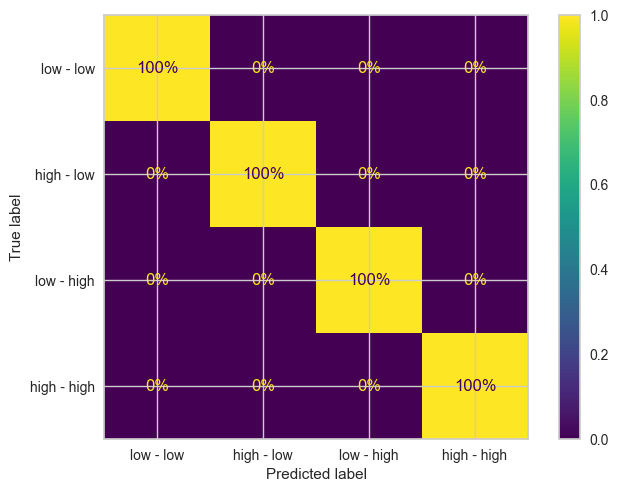

Model can't be displayed by Yellowbrick.
The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       1.00      1.00      1.00        34
  high - low       1.00      1.00      1.00        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      1.00      1.00        39

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [112]:
evaluate_model('GaussianNB', gnb_y_pred_test, str(gnb_clf.get_params()), gnb_y_pred_test, mean(gnb_cv), std(gnb_cv))

### Support Vector Machine

Quelle: [tds](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47) 

Support Vektor Maschinen sind Modelle aus dem Bereich supervised learning. Sie könne für Klassifikation und numerische Vorhersagen verwendet werden. Für die Klassifizierung versucht der Algorithmus eine mehrdimensionale Hyperplane zu finden, welche die Daten in die Kategorien aufteilt. Die Optimierung geschieht über die Maximierung des Abstands von Vektoren.

Für diese Daten könnte das Modell gut geeignet sein, da man für einige Parameter eine Entscheidungsgrenze im Verteilungplot schon erahnen kann. 

In [114]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_transformed, y_train)

svm_y_pred_test = svm_clf.predict(X_test_transformed)

In [115]:
svm_clf_pipe = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
    ('svc', SVC(random_state=42))
])
svm_cv = cross_val_score(svm_clf_pipe, X_train, y_train, cv=cv)

In [116]:
pd.Series(svm_cv).describe()

count    5.000000
mean     0.996491
std      0.007846
min      0.982456
25%      1.000000
50%      1.000000
75%      1.000000
max      1.000000
dtype: float64

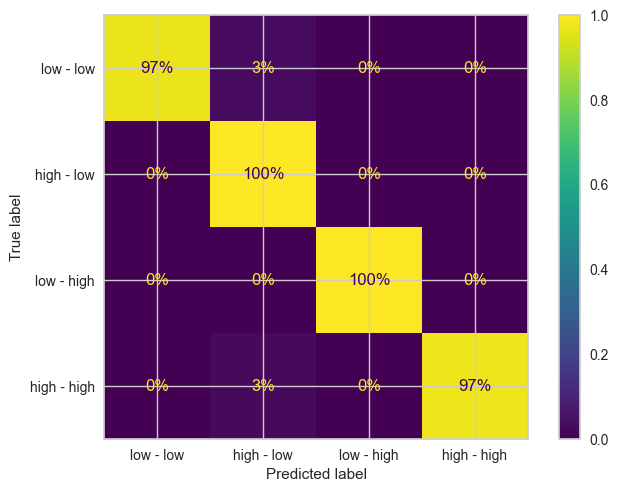

Model can't be displayed by Yellowbrick.
The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       1.00      0.97      0.99        34
  high - low       0.95      1.00      0.97        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      0.97      0.99        39

    accuracy                           0.98       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.98      0.98      0.98       122



In [117]:
evaluate_model('SVC', svm_clf, str(svm_clf.get_params()), svm_y_pred_test, mean(svm_cv), std(svm_cv))

### Decision Tree

Ein Decision Tree (z.d. Entscheidungsbaum) ist eine supervised learning Methode zur Regression oder Klassifikation von Daten, welche nach dem Teile-und-herrsche-Verfahren arbeitet. Dabei wird versucht aus einer Datenmenge heraus eine hierarchische Struktur (im Form eines Baumes) zu bilden, um Daten auf Grundlage von Regeln zu klassifizieren. 

In [118]:
dtc_clf = DecisionTreeClassifier(random_state=42)
dtc_clf.fit(X_train_transformed, y_train)

dtc_y_pred_test = dtc_clf.predict(X_test_transformed)

In [119]:
dtc_clf_pipe = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=42))
])
dtc_cv = cross_val_score(dtc_clf_pipe, X_train, y_train, cv=cv)

In [120]:
pd.Series(dtc_cv).describe()

count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64

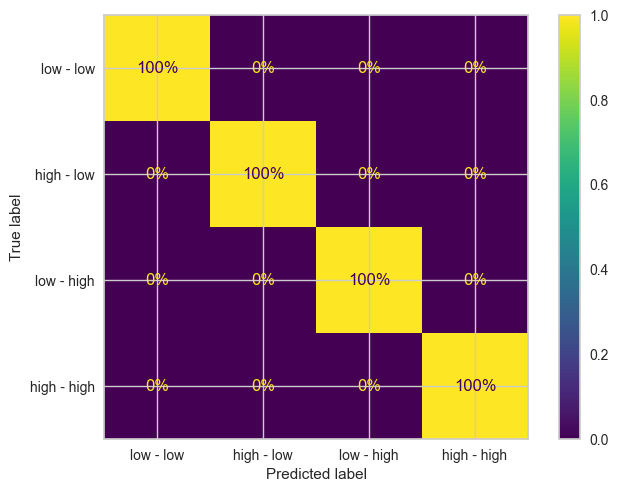

Model can't be displayed by Yellowbrick.


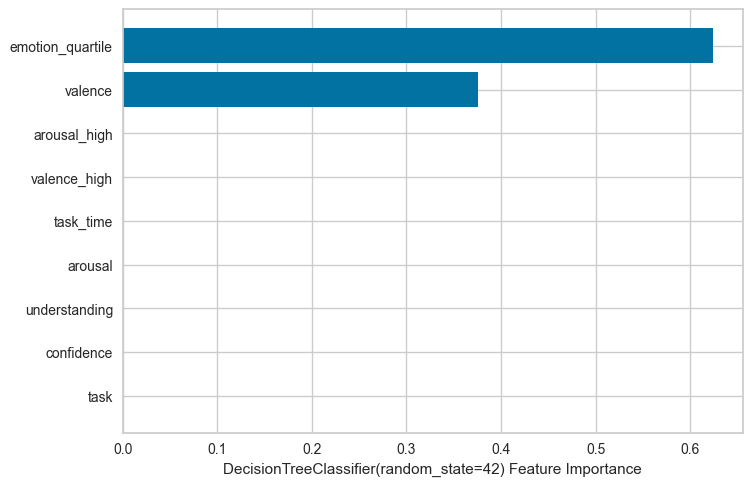

              precision    recall  f1-score   support

   low - low       1.00      1.00      1.00        34
  high - low       1.00      1.00      1.00        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      1.00      1.00        39

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [121]:
evaluate_model('DecisionTreeClassifier', dtc_clf, str(dtc_clf.get_params()), 
                dtc_y_pred_test, mean(dtc_cv), std(dtc_cv))

### Random Forest

Ein Random Forest Klassifikator ist ein Ensemble von Entscheidungsbäumen, die mit der Bagging-Methode trainiert werden, wobei die Auswahl an Attributen zufällig erfolgt (randomization). Bei der Bagging-Methode (Bootstrap Aggregation) werden mehrere zufällig gewählte Samples (ziehen mit zurücklegen) aus dem original Datensatz erstellt, um anschließend mehrere, in diesem Falle Entscheidungsbäume, unabhängig voneinander zu trainieren. Das bedeutet, dass die entstehenden Entscheidungsbäume nach unterschiedlichen Attribute splitten.



In [122]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_transformed, y_train)


rf_y_pred_test = rf_clf.predict(X_test_transformed)

In [123]:
rf_clf_pipe = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
rf_cv = cross_val_score(rf_clf_pipe, X_train, y_train, cv=cv, scoring="accuracy")

In [124]:
pd.Series(rf_cv).describe()

count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64

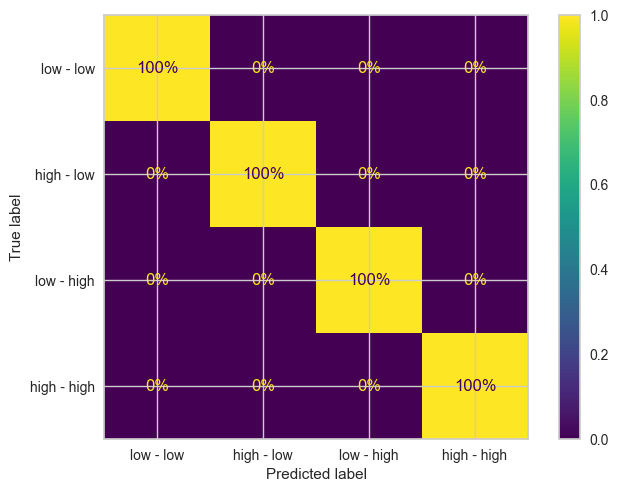

Model can't be displayed by Yellowbrick.


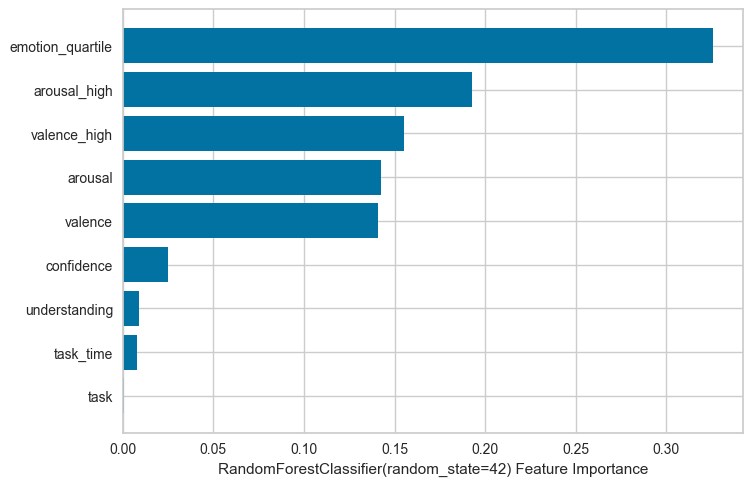

              precision    recall  f1-score   support

   low - low       1.00      1.00      1.00        34
  high - low       1.00      1.00      1.00        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      1.00      1.00        39

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [125]:
evaluate_model('RandomForestClassifier', rf_clf, str(rf_clf.get_params()), 
                rf_y_pred_test, mean(rf_cv), std(rf_cv))

### KNN (k-nearest-neighbors)

In [126]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, y_train)

knn_y_pred_test = knn_clf.predict(X_test_transformed)

In [127]:
knn_clf_pipe = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
    ('knn', KNeighborsClassifier())
    ])
knn_cv = cross_val_score(knn_clf_pipe, X_train, y_train, cv=cv)

In [128]:
pd.Series(knn_cv).describe()

count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64

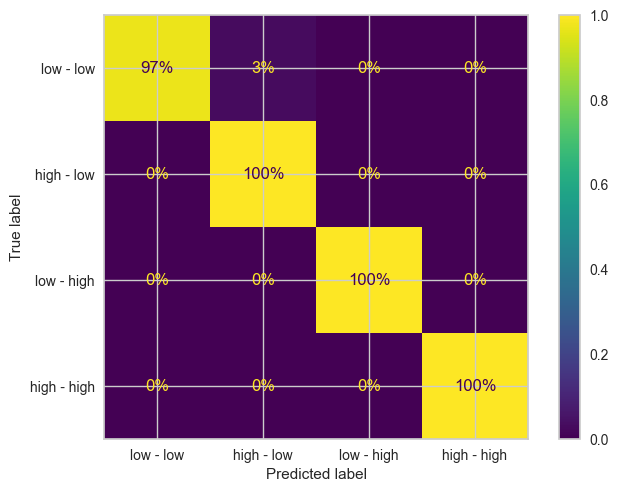

Model can't be displayed by Yellowbrick.
The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       1.00      0.97      0.99        34
  high - low       0.97      1.00      0.99        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      1.00      1.00        39

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122



In [129]:
evaluate_model('KNeighborsClassifier', knn_clf, str(knn_clf.get_params()), 
                knn_y_pred_test, mean(knn_cv), std(knn_cv))

### Logistic Regression Classifier

Quellen: [hackernoon](https://hackernoon.com/introduction-to-machine-learning-algorithms-logistic-regression-cbdd82d81a36)
[James, G., Witten, D., Hastie, T., & Tibshirani, R. (2017). An introduction to statistical learning : With applications in R (Corrected at 8th printing ed., Springer texts in statistics). New York Heidelberg Dordrecht London.](https://primo.bib.uni-mannheim.de/permalink/f/17313ps/MAN_ALMA21197109840002561)

Die Logistische Regression ist eine der am häufigsten Algorithmen für Klassifizierung. Die Klassifizierung funktioniert über das Anpassen einer Aktivierungsfunktion, der Sigmoid-Funktion.

*Logistic Regression is one of the simplest and most used regression algorithms. In contrast to linear Regression it doesn't have rely on a linear function. This can be used to make bettere classification predictions. It is based on an activation function, most of the time this activation function is a Sigmoid function. The Sigmoid function is very good in separating numeric values into two classes. Low negative values are mapped to -1 and high positive values are mapped to 1. The key however is the transition between the two classes, it is very narrow. Because it is so narrow the values are likely beeing classified as either -1 or 1. 

To optimize the output, we again need a cost function and the gradients, derived from the cost function. Here is the cost function: 

$$\frac{-1}{m}\sum^m_{i=1}y^{(i)}\log{h_\theta(x^{(i)})}+(1-y^{(i)}\log{(1-h_\theta(x^{(i)}))}$$

The gradient is the derivation of the cost function.*

Wir erwarten keine besonders gute Performance dieses Algorithmus, da für seine optimale Performance die Entscheidungsgrenzen sehr klar sein müssten zwischen den Variablen. 

In [130]:
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train_transformed, y_train)

lr_y_pred_test = lr_clf.predict(X_test_transformed)

In [131]:
lr_clf_pipe = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("standardize", StandardScaler()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])
lr_cv = cross_val_score(lr_clf_pipe, X_train, y_train, cv=cv)

In [132]:
pd.Series(lr_cv).describe()

count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64

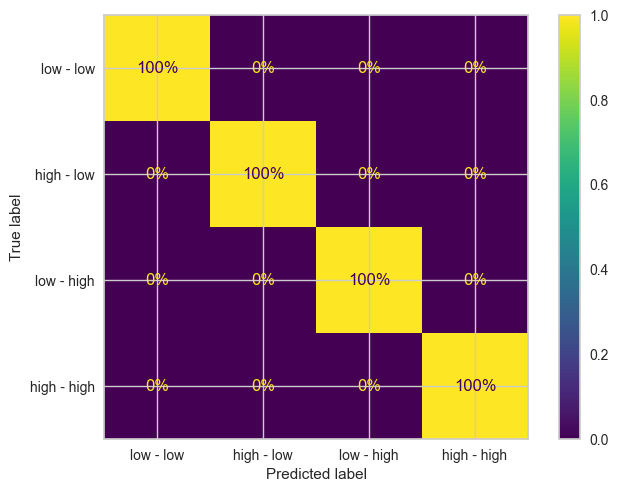

Model can't be displayed by Yellowbrick.
The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       1.00      1.00      1.00        34
  high - low       1.00      1.00      1.00        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      1.00      1.00        39

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [133]:
evaluate_model('LogisticRegression', lr_clf, str(lr_clf.get_params()), 
                lr_y_pred_test, mean(lr_cv), std(lr_cv))

### Ergebnisse

In [134]:
df_results.sort_values('accuracy_cv', ascending=False)

,modelname,hyperparameter,optimized,accuracy_cv,std_cv
0,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",False,1.000000,0.000000
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False,1.000000,0.000000
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",False,1.000000,0.000000
0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",False,1.000000,0.000000
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",False,1.000000,0.000000
0,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",False,0.996491,0.007018


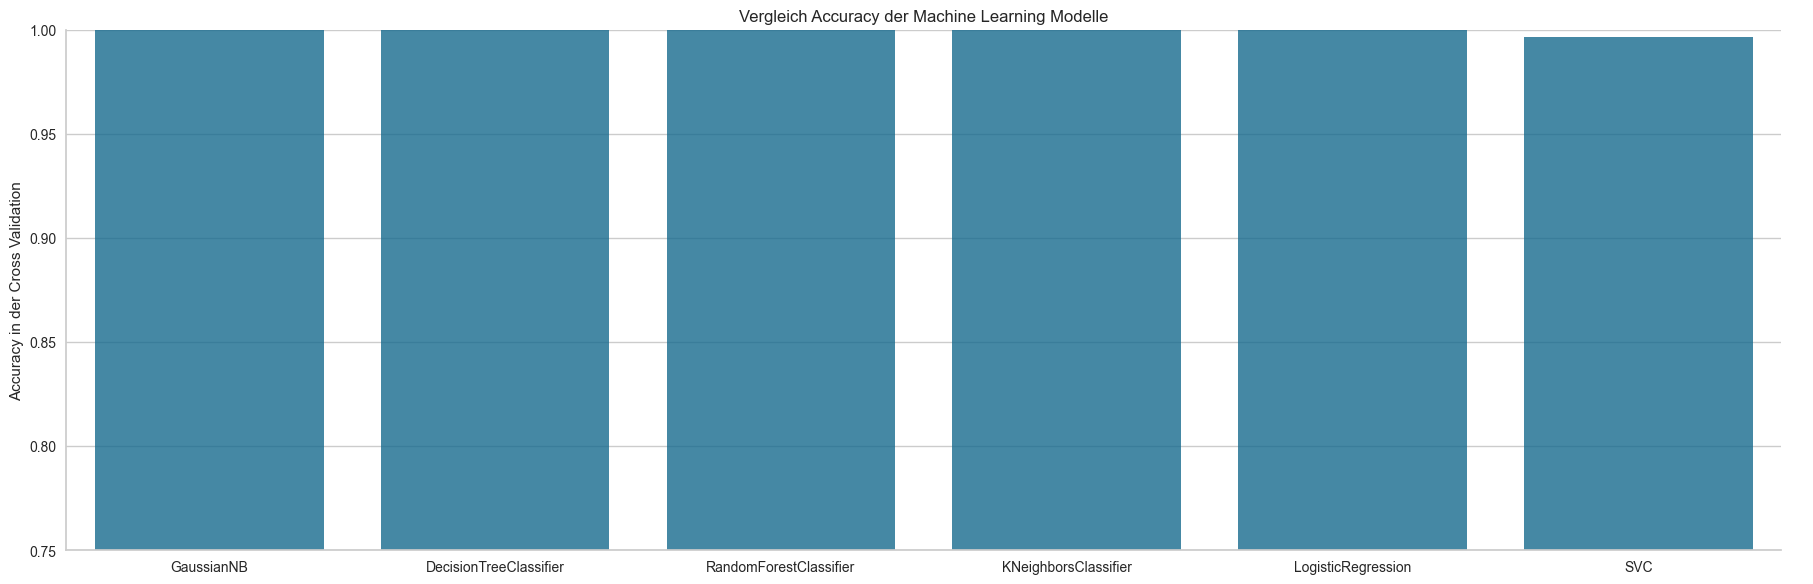

In [135]:
bp = sns.catplot(
    data=df_results.sort_values('accuracy_cv', ascending=False), 
    kind="bar",
    x="modelname", y="accuracy_cv",
    alpha=.8, height=6, aspect=3)
bp.set_axis_labels("", "Accuracy in der Cross Validation")
plt.title("Vergleich Accuracy der Machine Learning Modelle")
plt.ylim([0.75, 1.0])
plt.show()

## Optimiertes Modell Training

In [136]:
gnb_param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

knn_param_grid = {'n_neighbors': np.arange(4, 8),
                   'weights': ['uniform', 'distance'],
                   'metric': ['euclidean', 'manhattan']}
                   
dtc_param_grid = {'criterion':['gini', 'entropy'],'max_depth':[7,8,9,10,15,20,30]}

svm_param_grid = {'C': np.arange(9, 11), # tested with [3, 12]
                    'gamma': [1, 10, 100]} # tested with [0.001, 0.01, 0.1, 1, 10, 100]

rf_param_grid = {'min_samples_leaf': np.arange(3, 6), # tested with [2, 12]
                   'max_depth': np.arange(9, 12), # tested with [4, 15]
                   'min_samples_split': np.arange(2, 4)} # tested with [2, 12]

Die vorige Analyse der verschiedenen Modell für die Klassifizierung ließ uns eine erste Einschätzung der Güte der Modell treffen. Die vielversprechenden Kandidaten (random forest, knn, decision tree und logistic regression (*support vector machine fehlt*)) werden wir nun versuchen zu optimieren. Dafür wenden wir ein sogenanntes Hyperparametertuning mittels Grid-Search an. Das bedeutet, dass wir die Modelle vielfach mit verschiedenen Parametern trainieren, um die Performance weiter zu verbessern. Die Parameter unterscheiden sich dabei von Modell zu Modell, bspw. beim random forest optimieren wir die minimale beispiel blätter, maximale Tiefe und das minimale sample split.

Für die Optimierung verwenden wir die sklearn [GridSearchCV-Funktion](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Die Evaluierung der Modelle erfolgt über Cross-Validation

##### Cross Validation:
*hier noch Verweise auf Literatur*

Cross-Validation oder zu deutsch Kreuzvalidierung ist ein Verfahren, um Modelle zu evaluieren, ohne sie auf den Testdaten laufen zu lassen. Für die Cross-Validation wird der Trainingsdatensatz in n gleich große Teile gespalten. Dann wird einer dieser Teile als *validation set* zurück gehalten, während auf den verbliebenen n-1 Datensätzen gemeinsam das Modell trainiert wird. So können entweder n verschieden Modell trainiert werden oder, wie in unserem Fall, dasselbe Modell n mal, um einen Fehlerwert für die Vorhersagefähigkeit der Modell zu erhalten. 

In [137]:
gnb_grid_search = GridSearchCV(estimator=gnb_clf,
        param_grid=gnb_param_grid,
        scoring='accuracy',
        cv=cv)
        
svm_grid_search = GridSearchCV(estimator=svm_clf,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=cv)

rf_grid_search = GridSearchCV(estimator=rf_clf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=cv)

knn_grid_search = GridSearchCV(estimator=knn_clf,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=cv)

dtc_grid_search = GridSearchCV(estimator=dtc_clf,
        param_grid=dtc_param_grid,
        scoring='accuracy',
        cv=cv)

Logistic Regression konnte ich leider nicht optimieren, da es dort zu wenige Parameter zum einstellen gibt. 

In [138]:
grids = [gnb_grid_search, knn_grid_search, dtc_grid_search, svm_grid_search, rf_grid_search]
""" Auskommentiert aus Perfromancegründen
for pipe in grids:
    pipe.fit(X_train_transformed, y_train)
    print('Best Estimator: ', pipe.best_estimator_)
    print('Best Score: ', pipe.best_score_)
    print('Best Params: ', pipe.best_params_)
    # df_results.at[str(pipe.best_estimator_).split("(")[0], 'accuracy_cv'] = pipe.best_score_
    df_results = pd.concat([df_results, 
                            pd.DataFrame([{'modelname': str(pipe.best_estimator_).split("(")[0],
                                            'hyperparameter': pipe.best_params_,
                                            'accuracy_cv': pipe.best_score_,
                                            'optimized': True
                                        }])])

df_results.reset_index(inplace=True)
"""

' Auskommentiert aus Perfromancegründen\nfor pipe in grids:\n    pipe.fit(X_train_transformed, y_train)\n    print(\'Best Estimator: \', pipe.best_estimator_)\n    print(\'Best Score: \', pipe.best_score_)\n    print(\'Best Params: \', pipe.best_params_)\n    # df_results.at[str(pipe.best_estimator_).split("(")[0], \'accuracy_cv\'] = pipe.best_score_\n    df_results = pd.concat([df_results, \n                            pd.DataFrame([{\'modelname\': str(pipe.best_estimator_).split("(")[0],\n                                            \'hyperparameter\': pipe.best_params_,\n                                            \'accuracy_cv\': pipe.best_score_,\n                                            \'optimized\': True\n                                        }])])\n\ndf_results.reset_index(inplace=True)\n'

In [139]:
df_results.sort_values('accuracy_cv', ascending=False)

,modelname,hyperparameter,optimized,accuracy_cv,std_cv
0,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",False,1.000000,0.000000
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False,1.000000,0.000000
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",False,1.000000,0.000000
0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",False,1.000000,0.000000
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",False,1.000000,0.000000
0,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",False,0.996491,0.007018


### Bestes Modell: Random Forest

Wie oben in den Ergebnissen zu erkennen, performt der Random Forest in den meisten Fällen am besten. Daher trainieren wir hier nochmal anhand unseres Schemas den Random Forest:

In [140]:
rf_clf_opt = RandomForestClassifier(max_depth=11, min_samples_leaf=4, min_samples_split=2, random_state=42)
rf_clf_opt.fit(X_train_transformed, y_train)

rf_y_pred_test = rf_clf_opt.predict(X_test_transformed)

In [141]:
#import pickle
#with open('model.pkl', 'wb') as files:
#    pickle.dump(rf_clf_opt, files)
#with open('pipeline.pkl', 'wb') as files:
#    pickle.dump(pipeline, files)

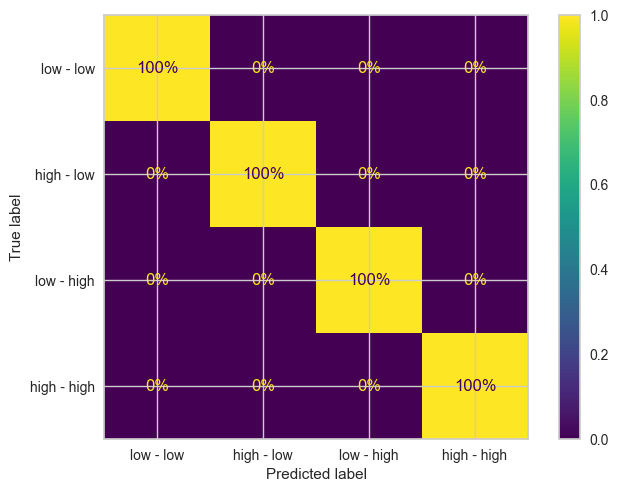

Model can't be displayed by Yellowbrick.


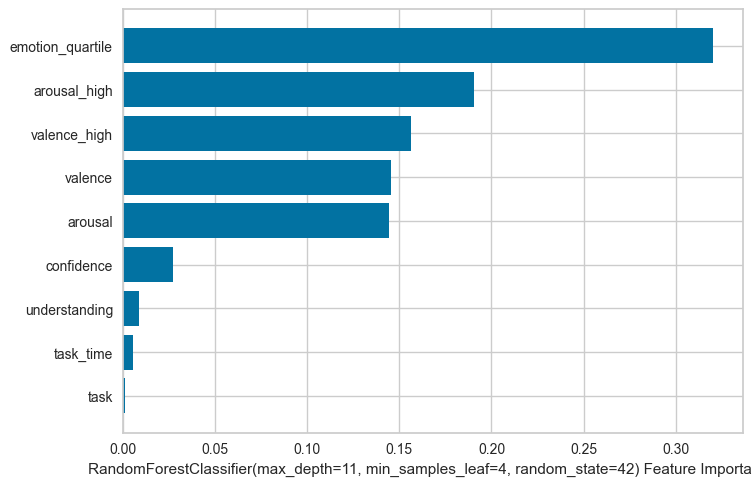

              precision    recall  f1-score   support

   low - low       1.00      1.00      1.00        34
  high - low       1.00      1.00      1.00        36
  low - high       1.00      1.00      1.00        13
 high - high       1.00      1.00      1.00        39

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [142]:
evaluate_model('RandomForestClassifierOptimised', rf_clf_opt, str(rf_clf_opt.get_params()), rf_y_pred_test, 0, 0, opt=True)

## Ensemble Learning

Quelle: [Kyriakides, G., & Margaritis, K. (2019). Hands-on ensemble learning with python : Build highly optimized ensemble machine learning models using scikit-learn and Keras (1st ed.). Birmingham ; Mumbai.](https://primo.bib.uni-mannheim.de/permalink/f/17313ps/MAN_ALMA51223994990002561)

Im Ensemble Learning werden mehrere Modelle sogenannte *base learners* oder *weak learners* trainiert. Deren Vorhersagen werden dann über verschiedene Techniken konsolidiert und zu einer insgesamt verbesserten Vorhersage zusammengefasst. Die bekanntesten Techniken des Ensemble Learnings sind Voting, Stacking, Bagging und Boosting.

Wir haben uns hier für einen simplen *Voting Classifier* entschieden.

Dieser basiert auf einem simplen Wählprinzip: Jeder der mittrainierten Schätzer gibt ein Votum über die Klasse ab. In unserem Fall sind die Schätzer die bereits vorgestellten ML-Algortihmen aus dem vorigen Kapitel. Wir haben die jeweils optimalen Parameter per Grid Search ermittelt und verwenden diese für das Training des Ensemble Classifiers. 

Wie auch von verschiedenen Demokratien bekannt, gibt es auch im Voting Classifier unterschiedliche Wahlsysteme. Das sogenannte *hard voting* entspricht dem Mehrheitswahlrecht. Die Klasse, welche die zahlenmäßig meisten Stimmen des Ensembles bekommt wird vom EnsembleClassifier vorhergesagt. Das *soft voting* berücksichtigt dagegen die unterschiedliche Wahrscheinlichkeit der Vorhersage. Es wird der Durchschnittswert der Vorhersagewahrscheinlichkeiten gebildet und dann die Klasse mit dem höchsten Durchschnittswert vorhergesagt. Die Voraussetzung für eine gute Performance des Voting Classifier ist demnach eine realistische Schätzung der Vorhersagewahrscheinlichkeit für die einzelnen Klassen. 

Da wir jeweils recht gute Vorhersagewerte für die einzelnen Klassen haben, ist bei uns die Verwendung des *soft voting* sinnvoll.


In [143]:
"""voting_clf = VotingClassifier(
    estimators=[
        ('gnb', GaussianNB(var_smoothing=3.5111917342151275e-06)),
        ('svm', SVC(random_state=42, probability=True, C=10, gamma=10, kernel='rbf')),
        ('rf', RandomForestClassifier(random_state=42, max_depth = 6, min_samples_leaf = 6, min_samples_split= 4)),
        ('dtc', DecisionTreeClassifier(random_state=42, max_depth = 30, criterion = 'gini')),
        ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors= 6, weights='distance')),
        ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
    ],
    voting='soft'
)
voting_clf.fit(X_train_transformed, y_train)"""


"voting_clf = VotingClassifier(\n    estimators=[\n        ('gnb', GaussianNB(var_smoothing=3.5111917342151275e-06)),\n        ('svm', SVC(random_state=42, probability=True, C=10, gamma=10, kernel='rbf')),\n        ('rf', RandomForestClassifier(random_state=42, max_depth = 6, min_samples_leaf = 6, min_samples_split= 4)),\n        ('dtc', DecisionTreeClassifier(random_state=42, max_depth = 30, criterion = 'gini')),\n        ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors= 6, weights='distance')),\n        ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))\n    ],\n    voting='soft'\n)\nvoting_clf.fit(X_train_transformed, y_train)"

In [144]:
# voting_y_pred_test = voting_clf.predict(X_test_transformed)

In [145]:
# voting_cv = cross_val_score(voting_clf, X_train_transformed, y_train, cv=3)

In [146]:
# pd.Series(voting_cv).describe()

In [147]:
# evaluate_model('VotingClassifier', voting_clf, str(voting_clf.get_params()), voting_y_pred_test, mean(voting_cv), std(voting_cv))

Mit diesem Voting Classifier haben wir nun all unsere Modell benutzt. Die Modelle scheinen sich allerdings nicht gut zu ergänzen, da wir insgesamt ein schlechteres Modell haben als das beste Modell ohne die Ensemble Learning Technik. Daher wollen wir hier nochmal ein Modell mit nur den 3 besten Performern trainieren:

In [148]:
voting_clf_3 = VotingClassifier(
    estimators=[
        ('svm', SVC(random_state=42, probability=True, C=10, gamma=10, kernel='rbf')),
        ('rf', RandomForestClassifier(random_state=42, max_depth = 6, min_samples_leaf = 6, min_samples_split= 4)),
        ('dtc', DecisionTreeClassifier(random_state=42, max_depth = 30, criterion = 'gini'))
    ],
    voting='soft'
)
voting_clf_3.fit(X_train_transformed, y_train)


VotingClassifier(estimators=[('svm',
                              SVC(C=10, gamma=10, probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_leaf=6,
                                                     min_samples_split=4,
                                                     random_state=42)),
                             ('dtc',
                              DecisionTreeClassifier(max_depth=30,
                                                     random_state=42))],
                 voting='soft')

In [149]:
#voting_3_y_pred_test = voting_clf_3.predict(X_test_transformed)

In [150]:
voting_cv_3 = cross_val_score(voting_clf_3, X_train_transformed, y_train, cv=3)

In [151]:
#pd.Series(voting_cv_3).describe()

In [152]:
#evaluate_model('VotingClassifier', voting_clf_3, str(voting_clf.get_params()), 
                #voting_3_y_pred_test, mean(voting_cv_3), std(voting_cv), opt=True)

Für uns überraschend, verbessert sich das Modell durch die Beschränkung auf die 3 besten Performer nur minimal. Vermutlich wurden die schlechten Performer auch im vorherigen Modell bereits überstimmt. Dann reiht sich das VotingEnsemble entsprechend der Performance der 3 enthaltenen Modelle ein. 

Unten ist nochmal die Übersicht für alle bislang trainierten Modell gezeigt, sortiert nach dem besten mittleren CV-Score

Eine weitere Option für die Optimierung ist das Setzen von Gewichten für die einzelnen Classifier. Gängig ist die Nutzung der Evaluierungswerte die zuvor beim Isolierten Training der Modell als Ergebnis standen. Daher wird im folgenden ein Array mit den Classifiern erstellt und der Voting Classifier nochmals trainiert. 

In [153]:
temp = df_results.sort_values(['modelname', 'accuracy_cv'], ascending = [True, False])

first = temp.groupby('modelname').first().reset_index()

weights = list(first['accuracy_cv'])

print('First: ', first)
print('Weights: ', weights)

First:                           modelname  \
0           DecisionTreeClassifier   
1                       GaussianNB   
2             KNeighborsClassifier   
3               LogisticRegression   
4           RandomForestClassifier   
5  RandomForestClassifierOptimised   
6                              SVC   

                                      hyperparameter optimized  accuracy_cv  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...     False     1.000000   
1           {'priors': None, 'var_smoothing': 1e-09}     False     1.000000   
2  {'algorithm': 'auto', 'leaf_size': 30, 'metric...     False     1.000000   
3  {'C': 1.0, 'class_weight': None, 'dual': False...     False     1.000000   
4  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...     False     1.000000   
5  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...      True     0.000000   
6  {'C': 1.0, 'break_ties': False, 'cache_size': ...     False     0.996491   

     std_cv  
0  0.000000  
1  0.000000  
2  0.000000 

In [154]:
voting_clf = VotingClassifier(
    estimators=[
        ('gnb', GaussianNB(var_smoothing=3.5111917342151275e-06)),
        ('svm', SVC(random_state=42, probability=True, C=10, gamma=10, kernel='rbf')),
        ('rf', RandomForestClassifier(random_state=42, max_depth = 6, min_samples_leaf = 6, min_samples_split= 4)),
        ('dtc', DecisionTreeClassifier(random_state=42, max_depth = 30, criterion = 'gini')),
        ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors= 6, weights='distance')),
        ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
    ],
    voting='soft'
)
voting_clf.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('gnb',
                              GaussianNB(var_smoothing=3.5111917342151275e-06)),
                             ('svm',
                              SVC(C=10, gamma=10, probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_leaf=6,
                                                     min_samples_split=4,
                                                     random_state=42)),
                             ('dtc',
                              DecisionTreeClassifier(max_depth=30,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=6,
                                                   weights='distance')),
                             ('lr', LogisticRegression(max_iter=5000))],
                 voting='soft')

# Deep Learning

Im Folgenden wird ein neuronales Netz für die vorliegende Klassifizierungsaufgabe trainiert. Zur Ermittlung der neuronalen Netzes mit der besten Performance wurden folgende Maßnahmen vorgenommen:
- Layer hinzugefügt
- Hidden Units hinzugefügt
- Andere Activation-Functions verwendet
- Andere Optimization-Functions verwendet
- Learning-Rate verändert
- Epochen erhöht

Das beste Ergebnis zahlreicher Versuche inklusive dessen Hyperparameter wird im nachfolgenden Code dargelegt.

In [155]:
# Validierungsdatensatz wird erstellt, welcher für das Trainieren und Optimieren des neuronalen Netzes benutzt wird
slicing_spot = int(len(X_test_transformed) / 2)
X_val, X_test_new = X_test_transformed[slicing_spot:], X_test_transformed[:slicing_spot]
y_val, y_test_new = y_test[slicing_spot:], y_test[:slicing_spot]

In [156]:
# Set random seed
tf.random.set_seed(42)

OptimalDense = partial(tf.keras.layers.Dense,
                           activation="selu",
                           kernel_initializer="lecun_normal",)

# Create the model
unoptimized_model = tf.keras.Sequential([
    OptimalDense(6)
] * 100)

unoptimized_model.add(OptimalDense(3, activation="softmax"))

# Compile the model
unoptimized_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True),
                 metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Ensure input data shapes are correct
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Ensure there are no NaN values in the input data
assert not tf.math.reduce_any(tf.math.is_nan(X_train_transformed)), "X_train_transformed contains NaN values"
assert not tf.math.reduce_any(tf.math.is_nan(y_train)), "y_train contains NaN values"
assert not tf.math.reduce_any(tf.math.is_nan(X_val)), "X_val contains NaN values"
assert not tf.math.reduce_any(tf.math.is_nan(y_val)), "y_val contains NaN values"

# Modell wird trainiert
unoptimized_model_history = unoptimized_model.fit(X_train_transformed, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

X_train_transformed shape: (283, 9)
y_train shape: (283,)
X_val shape: (61, 9)
y_val shape: (61,)


InvalidArgumentError: Value for attr 'T' of int64 is not in the list of allowed values: bfloat16, half, float, double
	; NodeDef: {{node IsNan}}; Op<name=IsNan; signature=x:T -> y:bool; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE]> [Op:IsNan]

Nachdem wir ein Modell mit Hyperparametern trainiert haben, welche laut [1] in der Regel am besten für diesen Typ von Aufgabe sind, haben wir viele verschiedene Modelle mit unterschiedlichen Hyperparametern wie z.B.
- Layer hinzugefügt
- Hidden Units hinzugefügt
- Andere Activation-Functions verwendet
- Andere Optimization-Functions verwendet
- Learning-Rate verändert
- Epochen erhöht
getestet. Letztendlich hat jedoch eine sehr einfaches neuronales Netz am besten performt:

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Standard Dense-Layer wird erstellt mit der Activation-Function "selu"
OptimalDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",)

# Modell bestehend aus 10 Standard Dense-Layern je 6 Hidden Units wird erstellt
optimized_model = tf.keras.Sequential([
    OptimalDense(10),
] * 20)

# Der Output-Layer wird final angehängt, welcher aus 3 Units besteht (je Klasse eine Unit)
# und via der Softmax-Activation eine aufsummierte Vorhersage (über alle Units) von 1 erzeugt
optimized_model.add(OptimalDense(3, activation="softmax"))

# Das Modell wird mit Loss-Function, Metrik und einem Optimizer kompiliert
optimized_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer='adam',
                 metrics=["accuracy"])

# Modell wird trainiert
optimized_model_history = optimized_model.fit(X_train_transformed, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


ValueError: Input 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 10)

In [ ]:
unoptimized_model_acc = unoptimized_model_history.history['accuracy']
unoptimized_model_val_acc = unoptimized_model_history.history['val_accuracy']
optimized_model_acc = optimized_model_history.history['accuracy']
optimized_model_val_acc = optimized_model_history.history['val_accuracy']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,10))
plt.plot(epochs, unoptimized_model_acc, 'bo', label='Training Accuracy des unoptimierten Modells')
plt.plot(epochs, unoptimized_model_val_acc, 'b', label='Validation Accuracy des unoptimierten Modells')
plt.plot(epochs, optimized_model_acc, 'go',  label='Training Accuracy des optimierten Modells')
plt.plot(epochs, optimized_model_val_acc, 'g', label='Validation Accuracy des optimierten Modells')
plt.title('Training and validation accuracy beider Modelle')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)

Finales evaluieren des besseren Modells auf den vorher nicht nie gesehenen Testdaten

In [ ]:
unoptimized_model_val_acc

In [ ]:
optimized_model_val_acc

In [ ]:
dl_loss, dl_accuracy = optimized_model.evaluate(X_test_new, y_test_new)

In [ ]:
df_results = pd.concat([df_results, 
                            pd.DataFrame([{'modelname': 'NeuralNetwork',
                                            'hyperparameter': r"{'activation': 'relu/softmax', 'kernel_initializer': 'he_normal', 'Optimizer': 'SGD with nesterov momentum'}",
                                            'accuracy_cv': dl_accuracy,
                                            'optimized' : True
                                        }])])

In [ ]:
df_results.drop(['index'], axis=1, inplace=True)
df_results.sort_values('accuracy_cv', ascending=False)

In [ ]:
bp = sns.catplot(
    data=df_results.sort_values('accuracy_cv', ascending=False), kind="bar",
    x="modelname", y="accuracy_cv", hue='optimized',
    # ci="std_cv",
    alpha=.8, height=6, aspect=3)
# bp.despine(left=True)
bp.set_axis_labels("", "Accuracy in der Cross Validation")
plt.title("Vergleich Accuracy der Machine Learning Modelle")
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
df_results.to_csv(f'results{date.today()}.csv')